# **1. 데이터셋 준비**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import os
import json
import zipfile
import random
import numpy as np
from PIL import Image

## **1-1. 데이터셋 불러오기**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**이미지 파일 압축 해제**
- 본인 경로를 제대로 설정했는지 확인
- 세션 디스크에 `data > train` 폴더를 만들어두고 압축 해제 진행하셔야 합니다..!
  - 세션 디스크 내 임시 경로로, 드라이브 x

```
!unzip (데이터 경로) -d (압축 해제할 경로)
```

In [ ]:
### 이미지 파일 압축 해제

!unzip /content/drive/MyDrive/Euron/6th-project/final/data/train.zip -d /content/data/train
!unzip /content/drive/MyDrive/Euron/6th-project/final/data/val.zip -d /content/data/val

In [4]:
### images 파일 준비

train_img_path = '/content/data/train'
val_img_path = '/content/data/val'

In [5]:
### annotations 파일 준비

train_annotations_path = '/content/drive/MyDrive/Euron/6th-project/final/data/coco_train.json'
val_annotations_path = '/content/drive/MyDrive/Euron/6th-project/final/data/coco_val.json'

## **1-2. Custom Dataset 준비**

In [6]:
### Custom Dataset 클래스 정의

class FashionDataset(Dataset):
  def __init__(self, annotation_file, image_dir, transform = None):
    with open(annotation_file, 'r') as f:
      self.coco_data = json.load(f)
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.coco_data['annotations'])

  def __getitem__(self, idx):
    ## 속성 정보
    annotation = self.coco_data['annotations'][idx]

    ## 이미지
    image_id = annotation['image_id']

    image_info = next((img for img in self.coco_data['images'] if img['id'] == image_id), None)
    image_path = os.path.join(self.image_dir, image_info['file_name'])

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    ## 캡션
    caption = annotation['caption']

    ## 속성
    attributes = annotation['attributes']

    ## 카테고리
    category = annotation['category']

    return image, caption, attributes, category

In [7]:
## 데이터셋 준비

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [8]:
train_dataset = FashionDataset(annotation_file = train_annotations_path,
                               image_dir = train_img_path,
                               transform = transform)

In [9]:
val_dataset = FashionDataset(annotation_file = val_annotations_path,
                               image_dir = val_img_path,
                               transform = transform)

In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  images, captions, attributes, categories = zip(*batch)

  # attributes 패딩 (빈 문자열로 패딩)
  max_attr_length = max(len(attr) for attr in attributes)
  padded_attributes = [attr + [""] * (max_attr_length - len(attr)) for attr in attributes]

  # 나머지는 그대로 처리
  images = torch.stack(images)
  captions = list(captions)
  categories = list(categories)

  return images, captions, padded_attributes, categories

In [11]:
### DataLoader 설정

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False, collate_fn = collate_fn)

# **2. Setup**

In [ ]:
!pip install peft

In [13]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AdamW, get_cosine_schedule_with_warmup

from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import get_peft_model, LoraConfig

## **2-1. model 준비**

In [14]:
### Pre-trained model 불러오기

# 전처리기
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", do_rescale=False)

# 모델
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [15]:
### 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [16]:
### target layer 가져오기
# 특정한 pattern으로 탐색

def get_target_modules(model, patterns):
  target_modules = []
  for name, module in model.named_modules():
    for pattern in patterns:
      if pattern in name:
        target_modules.append(name)
  return target_modules

In [17]:
## 예시
# 조합에 따라 바꿔야함(layer 찍어서 구조 확인해보기)

decoder_patterns = ["self.query", "self.key", "self.value", "intermediate.dense", "output.dense"]
encoder_patterns = ["self_attn.qkv", "mlp.fc"]

encoder_modules = get_target_modules(model, encoder_patterns)[-18:] # 마지막 6개 layer만 가져오려고..
                                                                    # 조건에 따라 바꿔야 함
decoder_modules = get_target_modules(model, decoder_patterns)

target_modules = encoder_modules+ decoder_modules

In [18]:
## PEFT + LoRA 설정

## LoRA Configuration
lora_config = LoraConfig(
    r = 16, # LoRA의 rank
    lora_alpha = 32, # LoRA의 alpha
    lora_dropout = 0.05, # LoRA의 dropout 비율
    target_modules = target_modules,
    bias = "none"
)

# LoRA 적용 모델
peft_model = get_peft_model(model, lora_config)

In [19]:
for modules in peft_model.targeted_module_names:
  print(modules)

vision_model.encoder.layers.18.self_attn.qkv
vision_model.encoder.layers.18.mlp.fc1
vision_model.encoder.layers.18.mlp.fc2
vision_model.encoder.layers.19.self_attn.qkv
vision_model.encoder.layers.19.mlp.fc1
vision_model.encoder.layers.19.mlp.fc2
vision_model.encoder.layers.20.self_attn.qkv
vision_model.encoder.layers.20.mlp.fc1
vision_model.encoder.layers.20.mlp.fc2
vision_model.encoder.layers.21.self_attn.qkv
vision_model.encoder.layers.21.mlp.fc1
vision_model.encoder.layers.21.mlp.fc2
vision_model.encoder.layers.22.self_attn.qkv
vision_model.encoder.layers.22.mlp.fc1
vision_model.encoder.layers.22.mlp.fc2
vision_model.encoder.layers.23.self_attn.qkv
vision_model.encoder.layers.23.mlp.fc1
vision_model.encoder.layers.23.mlp.fc2
text_decoder.bert.encoder.layer.0.attention.self.query
text_decoder.bert.encoder.layer.0.attention.self.key
text_decoder.bert.encoder.layer.0.attention.self.value
text_decoder.bert.encoder.layer.0.attention.output.dense
text_decoder.bert.encoder.layer.0.crossatt

In [20]:
peft_model # 학습을 위한 추가적인 layer들이 붙음

PeftModel(
  (base_model): LoraModel(
    (model): BlipForConditionalGeneration(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-17): 18 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=1024, out_features=3072, bias=True)
                (projection): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): BlipMLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                (fc2): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (layer_

## **2-2. Semantic metrics**

### **attribute-level semantic(ALS)**
- 이미지 속성들을 더 많이 포함한 문장을 생성하도록 유도
- 생성된 caption이 데이터의 속성을 얼마나 잘 포함하고 있는지 평가
    - 생성된 문장과 참조 문장에서 공통 attributes의 비율을 계산
    - 단순 개수 비교
- `reference_caption`에 적절한 속성이 없는 경우 보상을 0으로 설정하여 문제가 발생하지 않도록 하고 있음

In [21]:
import spacy

# SpaCy 모델 로드
nlp = spacy.load("en_core_web_sm")

In [22]:
def extract_attributes(caption):
  doc = nlp(caption)
  attributes = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]
  return attributes

In [23]:
def compute_als(generated_caption, reference_attributes):
  generated_attributes = extract_attributes(generated_caption)

  # 패딩된 속성 제거(공백)
  reference_attributes = [attr for attr in reference_attributes if attr != ""]

  common_attributes = set(generated_attributes) & set(reference_attributes)
  return len(common_attributes) / len(reference_attributes) if reference_attributes else 0

### **sentence-level semantic(SLS)**
- 패션 아이템의 카테고리를 더 정확하게 설명하도록 생성된 문장을 유도
- 생성된 caption이 category를 반영하고 있는지 평가
    - 포함되면 1, 아니면 0

In [24]:
def load_category_wordmap(file_path):
  with open(file_path, 'r') as f:
    return json.load(f)

category_wordmap = load_category_wordmap('/content/drive/MyDrive/Euron/6th-project/final/data/cates_wordmap.json')

In [25]:
def get_category_from_caption(caption):
    caption_words = set(caption.lower().split())
    for cat_id, cat_name in category_wordmap.items():
        if cat_name.lower() in caption_words:
            return int(cat_id)
    return None

In [26]:
def compute_sls(generated_caption, reference_category):
    predicted_category = get_category_from_caption(generated_caption)
    return 1.0 if predicted_category == reference_category else 0.0

### **전체 보상 함수**

In [27]:
def compute_rewards(preds, attributes, categories):
    als_rewards = [compute_als(pred, attr) for pred, attr in zip(preds, attributes)]
    sls_rewards = [compute_sls(pred, cat) for pred, cat in zip(preds, categories)]

    return als_rewards, sls_rewards

## **2-3. 평가 지표 준비**

In [ ]:
!git clone https://github.com/salaniz/pycocoevalcap
!pip install git+https://github.com/salaniz/pycocoevalcap.git

In [29]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [30]:
### 평가 지표 계산

def compute_metrics(preds, labels):
    scorers = [
        (Bleu(4), "BLEU-4"),
        (Meteor(), "METEOR"),
        (Rouge(), "ROUGE"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE")
    ]

    results = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score({i: [labels[i]] for i in range(len(labels))}, {i: [preds[i]] for i in range(len(preds))})
        results[method] = score if isinstance(score, float) else score[-1]

    return results

# **3. Fine-tuning**

## **3-1. 학습 & 검증**

In [31]:
### 옵티마이저 및 Learning Rate Schedule 정의

## 옵티마이저
optimizer = AdamW(filter(lambda p: p.requires_grad, peft_model.parameters()),
                  lr = 2e-5, weight_decay = 0.05)

## learning rate schedule
num_training_steps = len(train_loader) * 10  # 10 에포크
num_warmup_steps = int(0.1 * num_training_steps)  # Warmup 비율 10%
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

bleu_scores = []
meteor_scores = []
rouge_scores = []
cider_scores = []
spice_scores = []

In [33]:
def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs,
          start_epoch = 0, lambda_1 = 0.5, lambda_2 = 0.5):
    global best_val_loss

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"=== Epoch {epoch+1} ===")
        print("-" * 20)

        ## === Training ===
        model.train()
        epoch_train_loss = 0

        for images, captions, attributes, categories in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            inputs = processor(images=images, text=captions, return_tensors="pt", padding=True).to(device)

            outputs = model(**inputs, labels=inputs.input_ids)
            mle_loss = outputs.loss

            generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            als_rewards, sls_rewards = compute_rewards(generated_texts, attributes, categories)

            # MLE 손실 및 gradient 계산
            optimizer.zero_grad()
            mle_loss.backward(retain_graph=True)

            # REINFORCE를 통한 reward gradient 계산
            log_probs = torch.nn.functional.log_softmax(outputs.logits, dim=-1)
            input_ids_expanded = inputs.input_ids.unsqueeze(-1)
            gathered_log_probs = log_probs.gather(2, input_ids_expanded).squeeze(-1)

            batch_size, seq_length = gathered_log_probs.size()
            reward = torch.tensor(als_rewards, device=device).unsqueeze(1).expand(batch_size, seq_length)

            baseline = reward.mean()
            reinforce_loss = -torch.mean((reward - baseline) * gathered_log_probs)
            reinforce_loss.backward()

            optimizer.step()
            scheduler.step()

            total_loss = 0.5 * mle_loss + 0.5 * reinforce_loss
            epoch_train_loss += total_loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"Train Loss: {avg_train_loss:.4f}")


        ## === Validation ===
        model.eval()
        epoch_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, captions, attributes, categories in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device)
                inputs = processor(images=images, text=captions, return_tensors="pt", padding=True).to(device)

                outputs = model(**inputs, labels=inputs.input_ids)
                val_loss = outputs.loss
                epoch_val_loss += val_loss.item()

                generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
                generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

                all_preds.extend(generated_texts)
                all_labels.extend(captions)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Validation Loss: {avg_val_loss:.4f}")


        ## == Evaluation ==
        # Calculate evaluation metrics
        metrics = compute_metrics(all_preds, all_labels)

        bleu_scores.append(metrics['BLEU-4'])
        meteor_scores.append(metrics['METEOR'])
        rouge_scores.append(metrics['ROUGE'])
        cider_scores.append(metrics['CIDEr'])
        spice_scores.append(metrics['SPICE'])

        print(f"BLEU: {metrics['BLEU-4']:.4f}, METEOR: {metrics['METEOR']:.4f}, ROUGE: {metrics['ROUGE']:.4f}, CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}")

        # Best model 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/Euron/6th-project/final/model/model_trial_4.pth")
            print(f"Model saved at Epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

        # Clear cache
        torch.cuda.empty_cache()

In [34]:
# 모델 학습

num_epochs = 10
train(peft_model, train_loader, val_loader, optimizer, scheduler, device, num_epochs)

=== Epoch 1 ===
--------------------


Training Epoch 1/10: 100%|██████████| 625/625 [56:01<00:00,  5.38s/it]


Train Loss: 2.9851


Validating Epoch 1/10: 100%|██████████| 63/63 [05:12<00:00,  4.96s/it]


Validation Loss: 5.0660
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
{'testlen': 18286, 'reflen': 21189, 'guess': [18286, 17286, 16286, 15286], 'correct': [4209, 544, 63, 7]}
ratio: 0.8629949502099739
BLEU: 0.0091, METEOR: 0.0706, ROUGE: 0.1665, CIDEr: 0.1595, SPICE: 0.0730
Model saved at Epoch 1 with Validation Loss: 5.0660
=== Epoch 2 ===
--------------------


Training Epoch 2/10: 100%|██████████| 625/625 [1:05:42<00:00,  6.31s/it]


Train Loss: 2.4670


Validating Epoch 2/10: 100%|██████████| 63/63 [05:06<00:00,  4.86s/it]


Validation Loss: 4.7807
{'testlen': 19144, 'reflen': 21189, 'guess': [19144, 18144, 17144, 16144], 'correct': [4585, 633, 117, 22]}
ratio: 0.9034876586907875
BLEU: 0.0150, METEOR: 0.0816, ROUGE: 0.1715, CIDEr: 0.2199, SPICE: 0.0820
Model saved at Epoch 2 with Validation Loss: 4.7807
=== Epoch 3 ===
--------------------


Training Epoch 3/10: 100%|██████████| 625/625 [1:04:12<00:00,  6.16s/it]


Train Loss: 2.3837


Validating Epoch 3/10: 100%|██████████| 63/63 [04:55<00:00,  4.70s/it]


Validation Loss: 4.6959
{'testlen': 19394, 'reflen': 21189, 'guess': [19394, 18394, 17394, 16394], 'correct': [4679, 724, 121, 24]}
ratio: 0.9152862334229593
BLEU: 0.0161, METEOR: 0.0851, ROUGE: 0.1785, CIDEr: 0.2360, SPICE: 0.0859
Model saved at Epoch 3 with Validation Loss: 4.6959
=== Epoch 4 ===
--------------------


Training Epoch 4/10: 100%|██████████| 625/625 [1:04:11<00:00,  6.16s/it]


Train Loss: 2.3392


Validating Epoch 4/10: 100%|██████████| 63/63 [05:08<00:00,  4.90s/it]


Validation Loss: 4.6494
{'testlen': 20663, 'reflen': 21189, 'guess': [20663, 19663, 18663, 17663], 'correct': [4920, 795, 143, 35]}
ratio: 0.9751757987634633
BLEU: 0.0191, METEOR: 0.0885, ROUGE: 0.1814, CIDEr: 0.2462, SPICE: 0.0926
Model saved at Epoch 4 with Validation Loss: 4.6494
=== Epoch 5 ===
--------------------


Training Epoch 5/10: 100%|██████████| 625/625 [1:04:59<00:00,  6.24s/it]


Train Loss: 2.3126


Validating Epoch 5/10: 100%|██████████| 63/63 [05:13<00:00,  4.98s/it]


Validation Loss: 4.6232
{'testlen': 20960, 'reflen': 21189, 'guess': [20960, 19960, 18960, 17960], 'correct': [4959, 808, 140, 30]}
ratio: 0.9891925055452834
BLEU: 0.0183, METEOR: 0.0876, ROUGE: 0.1818, CIDEr: 0.2477, SPICE: 0.0893
Model saved at Epoch 5 with Validation Loss: 4.6232
=== Epoch 6 ===
--------------------


Training Epoch 6/10: 100%|██████████| 625/625 [1:05:57<00:00,  6.33s/it]


Train Loss: 2.2935


Validating Epoch 6/10: 100%|██████████| 63/63 [05:22<00:00,  5.12s/it]


Validation Loss: 4.6071
{'testlen': 21527, 'reflen': 21189, 'guess': [21527, 20527, 19527, 18527], 'correct': [5002, 786, 146, 42]}
ratio: 1.015951673037849
BLEU: 0.0197, METEOR: 0.0887, ROUGE: 0.1806, CIDEr: 0.2512, SPICE: 0.0891
Model saved at Epoch 6 with Validation Loss: 4.6071
=== Epoch 7 ===
--------------------


Training Epoch 7/10: 100%|██████████| 625/625 [1:06:17<00:00,  6.36s/it]


Train Loss: 2.2885


Validating Epoch 7/10: 100%|██████████| 63/63 [05:28<00:00,  5.21s/it]


Validation Loss: 4.5968
{'testlen': 21778, 'reflen': 21189, 'guess': [21778, 20778, 19778, 18778], 'correct': [4993, 801, 149, 35]}
ratio: 1.0277974420689495
BLEU: 0.0188, METEOR: 0.0884, ROUGE: 0.1821, CIDEr: 0.2517, SPICE: 0.0931
Model saved at Epoch 7 with Validation Loss: 4.5968
=== Epoch 8 ===
--------------------


Training Epoch 8/10: 100%|██████████| 625/625 [1:06:48<00:00,  6.41s/it]


Train Loss: 2.2740


Validating Epoch 8/10: 100%|██████████| 63/63 [05:28<00:00,  5.22s/it]


Validation Loss: 4.5922
{'testlen': 20919, 'reflen': 21189, 'guess': [20919, 19919, 18919, 17920], 'correct': [4863, 726, 121, 25]}
ratio: 0.9872575392892072
BLEU: 0.0164, METEOR: 0.0867, ROUGE: 0.1795, CIDEr: 0.2421, SPICE: 0.0898
Model saved at Epoch 8 with Validation Loss: 4.5922
=== Epoch 9 ===
--------------------


Training Epoch 9/10: 100%|██████████| 625/625 [1:07:04<00:00,  6.44s/it]


Train Loss: 2.2750


Validating Epoch 9/10: 100%|██████████| 63/63 [05:29<00:00,  5.24s/it]


Validation Loss: 4.5909
{'testlen': 21267, 'reflen': 21189, 'guess': [21267, 20267, 19267, 18268], 'correct': [4869, 745, 126, 27]}
ratio: 1.0036811553163905
BLEU: 0.0169, METEOR: 0.0873, ROUGE: 0.1782, CIDEr: 0.2409, SPICE: 0.0888
Model saved at Epoch 9 with Validation Loss: 4.5909
=== Epoch 10 ===
--------------------


Training Epoch 10/10: 100%|██████████| 625/625 [1:07:22<00:00,  6.47s/it]


Train Loss: 2.2728


Validating Epoch 10/10: 100%|██████████| 63/63 [05:31<00:00,  5.26s/it]


Validation Loss: 4.5907
{'testlen': 21371, 'reflen': 21189, 'guess': [21371, 20371, 19371, 18372], 'correct': [4885, 759, 133, 33]}
ratio: 1.0085893624049738
BLEU: 0.0180, METEOR: 0.0876, ROUGE: 0.1782, CIDEr: 0.2442, SPICE: 0.0905
Model saved at Epoch 10 with Validation Loss: 4.5907


- layer 풀어주는 개수에 따라서 사용되는 리소스가 달라지니, GPU는 알아서 선택적으로 활용하세요.
  - T4도 버티기는 하는데 조금 불안불안하네요,,
  - GPU 종류 선택 자체가 모델링 성능에 미치는 영향은 다른 조건들이 모두 동일하기에 매우 미미함

## **3-2. 결과 시각화**

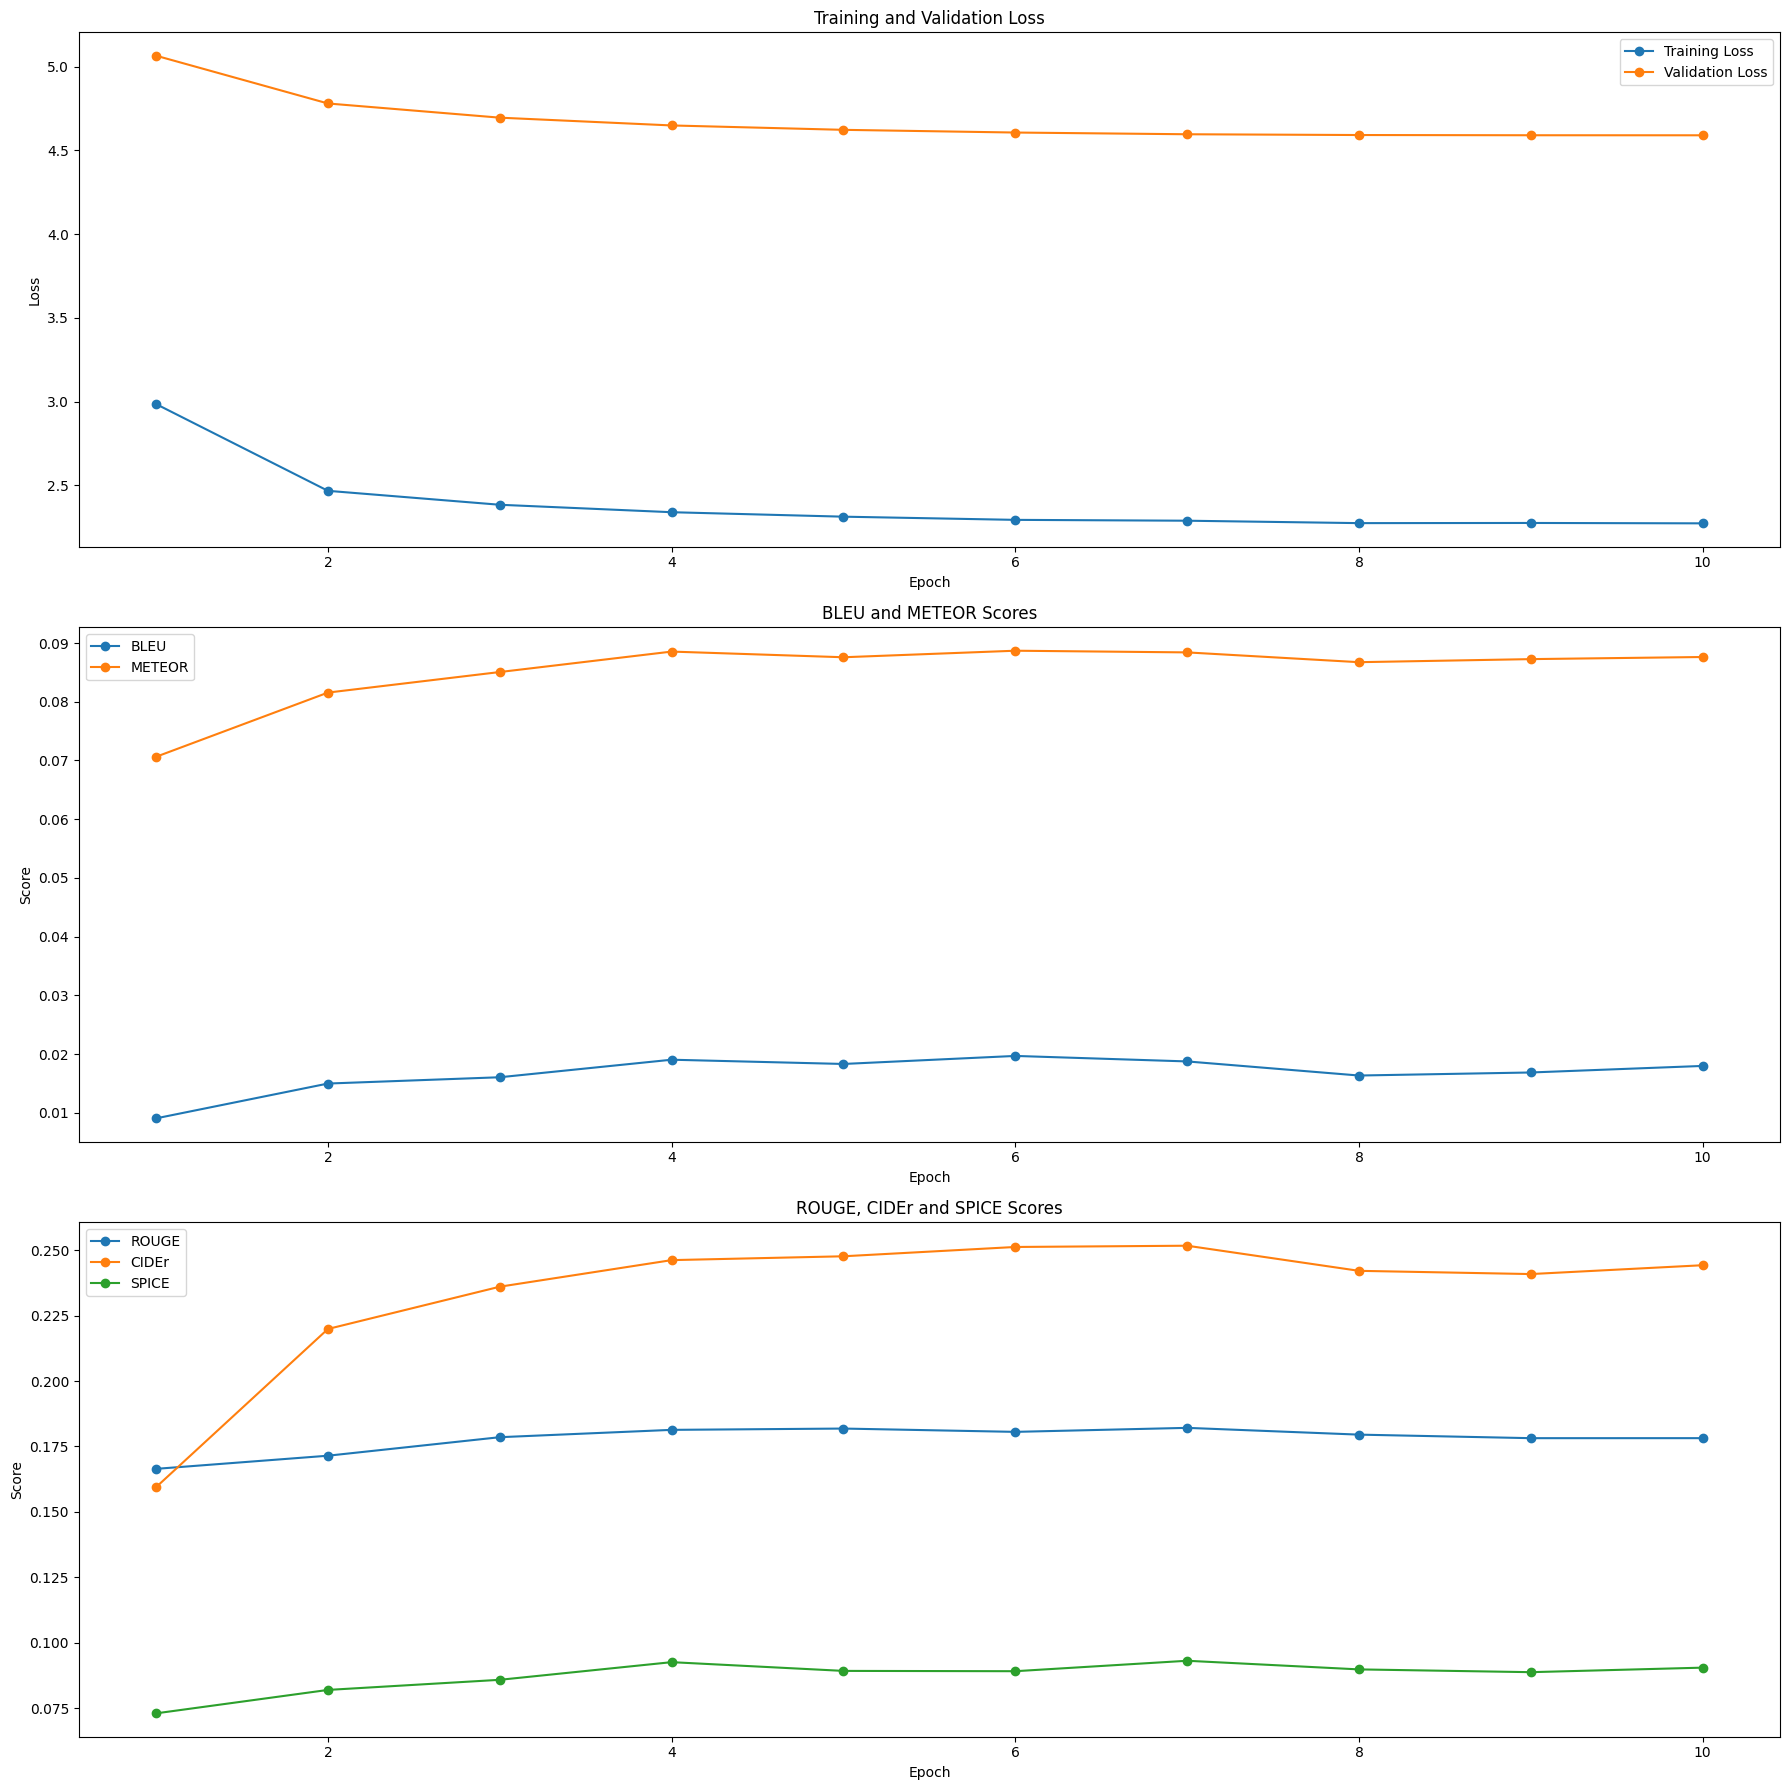

In [35]:
### 시각화

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(18, 18))

# 손실 곡선
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 평가 지표 1 (BLEU, METEOR)
plt.subplot(3, 1, 2)
plt.plot(epochs, bleu_scores, marker='o', label='BLEU')
plt.plot(epochs, meteor_scores, marker='o', label='METEOR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('BLEU and METEOR Scores')
plt.legend()

# 평가 지표 2 (ROUGE, CIDEr, SPICE)
plt.subplot(3, 1, 3)
plt.plot(epochs, rouge_scores, marker='o', label='ROUGE')
plt.plot(epochs, cider_scores, marker='o', label='CIDEr')
plt.plot(epochs, spice_scores, marker='o', label='SPICE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('ROUGE, CIDEr and SPICE Scores')
plt.legend()

plt.tight_layout()
plt.show()